# Intro to Developmental Interpretability

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/introduction.ipynb)

Developmental interpretability ("devinterp") studies how structure develops over the course of training. 

## Aim

Our aim is to develop tools for detecting, understanding, and preventing dangerous transitions during training — to capabilities, values, behaviors. 

This library is where we'll put those tools. **It's very much a work in progress** (and we welcome contributions).

## Set-up

In [1]:
%pip install transformers torchvision
%cd ..
%pip install -e .


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/home/paperspace/devinterp
Obtaining file:///home/paperspace/devinterp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for devinterp (pyproject.toml) ... done
  Created wheel for devinterp: filename=devinterp-0.1.0-0.editable-py3-none-any.whl size=3491 sha256=a8f3498cb96a8bbcaa8c0beeab91a1107167d303ea2e594323463d87f12864d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-r9epaibj/wheels/91/e6/e0/019210957504227ae25445ed529a61d17d33409b6696c34298
Successfully built devinterp
  Attempting uninstall: devinterp
    Found existing installation: devinterp 0.1.0
    Uninstalling devinterp-0.1.0:
      Successfully uninstalled devinterp-0.1.0

# Methods

## Local Learning Coefficients

The first method we have have online is local learning coefficient estimation ([Lau et al. 2023](https://arxiv.org/abs/2308.12108)). 

For an in-depth explaination, see [this post](https://www.lesswrong.com/posts/6g8cAftfQufLmFDYT/you-re-counting-your-parameters-wrong). The short version is that: 
- The (local) learning coefficient $\hat\lambda$ is the "correct" measure of model complexity. Besides the loss, it's the most principled high-level way to compare models.
- We can cheaply estimate the learning coefficient associated to a choice of weights $\hat w^*$ by using the following formula:

$$
\hat\lambda(\hat w^*)=\frac{\mathbb{E}_{w|\hat w^*, \gamma}^{\beta^*}\left[n L_n(w)\right] - n L_n(\hat w^*)}{\log n}.
$$

where, $n$ is the number of (training) samples, $L_n(w)$ is the negative log likelihood (i.e., your objective function), and $\mathbb{E}_w^{\beta^*}\left[n L_n(w)\right]$ is a "local average" of $nL_n(w)$ over a neighborhood of $\hat w^*$. The parameters $\gamma$ and $\beta^*$ control the local averaging.

The difficulty is in performing the local average: we need to sample enough points and they need to be both diverse / spread out enough and close enough to the starting weight. To make sure they're spread out enough we use an optimizer like Stochastic Gradient Langevin Dynamics (SGLD), which is SGD plus Gaussian noise.


In [2]:
import yaml

import torch
import torchvision
from transformers import AutoModelForImageClassification
from torch.nn import functional as F

from devinterp.slt import estimate_learning_coeff_with_summary
from devinterp.optim import SGLD
from devinterp.utils import plot_trace

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Load a pretrained MNIST classifier
model = AutoModelForImageClassification.from_pretrained("fxmarty/resnet-tiny-mnist")
data = torchvision.datasets.MNIST(
    root="../data",
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
        ]
    ),
)
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True)
print(len(loader))

def criterion(inputs, outputs):
    return F.cross_entropy(
        inputs.logits, outputs
    )  # transformers doesn't output a vector


learning_coeff_stats = estimate_learning_coeff_with_summary(
    model,
    loader=loader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=2e-5, localization=100.0),
    num_chains=5,  # How many independent chains to run
    num_draws=300,  # How many samples to draw per chain
    num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
    num_steps_bw_draws=1,  # How many steps to take between each sample
    device=DEVICE,
    online=True
)
trace = learning_coeff_stats.pop("llc/trace")
print(trace)

print("Lambda hat estimates:")
print(yaml.dump(learning_coeff_stats))

/home/paperspace/devinterp/src/devinterp/slt/sampler.py:129: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/paperspace/devinterp/src/devinterp/slt/sampler.py:133: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(


235


Chain 0:   1%|          | 2/300 [00:00<00:16, 18.17it/s]

0.0532807819545269 4.48175048828125


Chain 1:   1%|▏         | 4/300 [00:00<00:16, 18.23it/s]

0.048797737807035446 4.48175048828125


Chain 2:   1%|▏         | 4/300 [00:00<00:16, 17.75it/s]

0.026111191138625145 4.48175048828125


Chain 3:   1%|          | 3/300 [00:00<00:28, 10.34it/s]

0.04358084872364998 4.48175048828125


Chain 4:   1%|▏         | 4/300 [00:00<00:16, 18.22it/s]

0.05440887063741684 4.48175048828125


Chain 4: 100%|██████████| 300/300 [00:14<00:00, 21.41it/s]

[[-24150.68  -24179.92  -24153.537 ... -23612.873 -23611.744 -23611.785]
 [-24175.129 -24018.232 -23971.498 ... -23623.656 -23623.504 -23624.195]
 [-24298.85  -24246.781 -24155.38  ... -23601.578 -23602.09  -23601.758]
 [-24203.576 -24228.64  -24128.342 ... -23641.967 -23641.895 -23640.895]
 [-24144.525 -24120.645 -24128.93  ... -23602.8   -23603.14  -23603.35 ]]
Lambda hat estimates:
llc/means: !!python/object/apply:numpy.core.multiarray._reconstruct
  args:
  - &id001 !!python/name:numpy.ndarray ''
  - !!python/tuple
    - 0
  - !!binary |
    Yg==
  state: !!python/tuple
  - 1
  - !!python/tuple
    - 300
  - &id002 !!python/object/apply:numpy.dtype
    args:
    - f4
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
    - null
    - null
    - -1
    - -1
    - 0
  - false
  - !!binary |
    GwW9xrC9vMYUV7zGExG8xjXku8Y4t7vGLZi7xh5vu8b4RrvG7Di7xp0fu8a/AbvGWPy6xl/vusb6
    4LrGa926xlLXusYHz7rGl9S6xkfPusZLyrrG1se6xh+8usayurrGJbG6xl+kusaFlbrG44+6xo+N
    usZLi

### Diagnostics

Below you'll see what's actually happening when you run `local_learning_coefficients`.

We sample 10 different chains, with the same starting positions but different batch schedules and noise realizations at each step. For each of these chains, we take 200 steps using SGLD. We observe the loss at each of these points. At the end, we average the loss across chains, compare it to the initial loss, and apply a correction that depends on the dataset size to get the local learning coefficient. 

For a healthy chain, the LLC should increase rapidly at first and then level off.

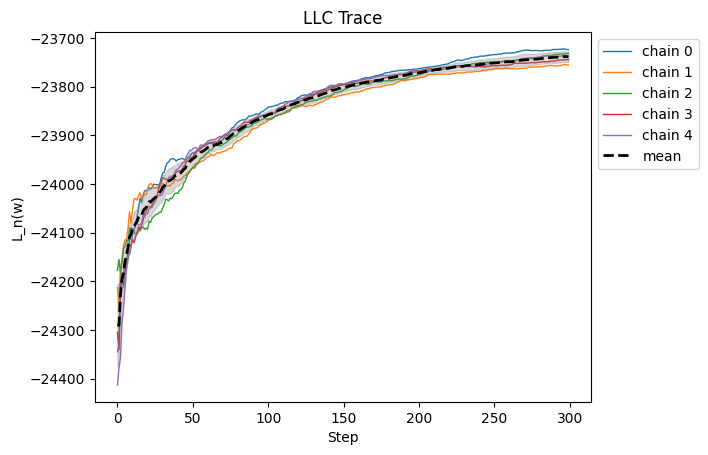

<Figure size 1200x900 with 0 Axes>

In [4]:
plot_trace(
    trace,
    "L_n(w)",
    x_axis="Step",
    title="LLC Trace",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

To get a better understanding of the sampling methods, check out [`normal_crossing.ipynb`](../examples/normal_crossing.ipynb) and [`mnist.ipynb`](../examples/mnist.ipynb) where we compare SGLD to a variant known as Stochastic Gradient Nose-Hoover Thermostat (SGNHT), respectively in a simple toy landscape and on MNIST. [`sgld_calibration.ipynb`](../examples/sgld_calibration.ipynb) shows how to gain confidence in using SGLD-based LLC estimation to a model with unknown LLC, and [`diagnostics.ipynb`](../examples/diagnostics.ipynb) shows how to use callbacks to diagnose if your sampling is going well.

## Project ideas

What can you do with this? We wrote up [a bunch of ideas](https://devinterp.com/projects), most of which are focused on learning coefficient estimation, and we'd recommend starting there. There's a lot of low-hanging fruit. 

## Other Techniques

There are plenty of other techniques that would fit naturally under the umbrella of "developmental interpretability." If you're interested in looking beyond learning coefficient estimation, here are some ideas (we welcome PRs to introduce these methods to the library!):

- **Dimensionality reduction techniques**: Run PCA / t-SNE / UMAP / etc. over the weights / [tokens](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html#per-token-loss-intro) / activations over time. For larger models, you'll have to restrict your attention to a subset of the weights and activations for this to be tractable
- **Progress measures**. If you have an understanding of some structure at the end of training, you can roll that understanding backwards to track how that structure develops over time. 
- **Probes**. Similarly, you can train a linear probe from activations onto features, then roll that probe back to previous checkpoints to measure how those features are learned. 
- **Gradients**. Just look at the gradients! 
- **Evals**. You can measure performance on a targeted benchmarks to track when the model learns the associated capabilities. 
- **Covariance estimators**. That's a secret for now. More coming soon!

# Systems

## Toy Landscapes

See [`normal_crossing.ipynb`](../examples/normal_crossing.ipynb) for a demo of how to use the library on a simple toy landscape.

## Toy Models of Superposition

See [`tms.ipynb`](../examples/tms.ipynb) for a demo of how to use the library on toy models of superposition.

## Deep Linear Networks

See [`dlns.ipynb`](../examples/dlns.ipynb) for a demo of how to use the library on deep linear networks.

## MNIST

See [`mnist.ipynb`](../examples/mnist.ipynb) for a demo of how to use the library on MNIST.

## ResNets

See [`resnets.ipynb`](../examples/resnets.ipynb) for a (basic) demo of how to use the library on ResNets.